In [2]:
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv('lending_club_loan_two.csv')

In [4]:
df['loan_repaid'] = df['loan_status'].map({'Fully Paid':1,'Charged Off':0})

In [5]:
df = df.drop('emp_title',axis=1)

In [6]:
emp_co = df[df['loan_status']=='Charged Off'].groupby('emp_length').count()['loan_status']
emp_fp = df[df['loan_status']=='Fully Paid'].groupby('emp_length').count()['loan_status']

In [7]:
df = df.drop('emp_length',axis=1)

In [8]:
df = df.drop('title',axis=1)

In [9]:
total_acc_avg = df.groupby('total_acc').mean()['mort_acc']

# %%
# filling out missing values in mort_acc
def fill_mort_acc(total_acc,mort_acc):
    if np.isnan(mort_acc):
        return total_acc_avg[total_acc]
    else:
        return mort_acc

# %%
df['mort_acc'] = df.apply(lambda x: fill_mort_acc(x['total_acc'],x['mort_acc']),axis=1)

/tmp/ipykernel_11136/1719564190.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  total_acc_avg = df.groupby('total_acc').mean()['mort_acc']


In [10]:
df = df.dropna()

In [11]:
dummies = pd.get_dummies(df[['verification_status','application_type','initial_list_status','purpose']],drop_first=True)
df = pd.concat([df.drop(['verification_status','application_type','initial_list_status','purpose'],axis=1),dummies],axis=1)

In [12]:
df['home_ownership'] = df['home_ownership'].replace(['NONE','ANY'],'OTHER')

# %%
dummies = pd.get_dummies(df['home_ownership'],drop_first=True)
df = pd.concat([df.drop(['home_ownership'],axis=1),dummies],axis=1)

In [13]:
df['address'].apply(lambda address:address[-5:])

# %%
df['zip_code'] = df['address'].apply(lambda address:address[-5:])

In [14]:
dummies = pd.get_dummies(df['zip_code'],drop_first=True)
df = pd.concat([df.drop(['zip_code'],axis=1),dummies],axis=1)

# %%
df = df.drop('address',axis=1)
df = df.drop('issue_d',axis=1)
df['earliest_cr_line'] = df['earliest_cr_line'].apply(lambda date: int(date[-4:]))
df = df.drop('grade',axis=1)
subgrade_dummies = pd.get_dummies(df['sub_grade'],drop_first=True)

# %%
df = pd.concat([df.drop('sub_grade',axis=1),subgrade_dummies],axis=1)

# %%
dummies = pd.get_dummies(df['term'],drop_first=True)
df = pd.concat([df.drop(['term'],axis=1),dummies],axis=1)

# %%
dummies = pd.get_dummies(df['loan_status'],drop_first=True)
df = pd.concat([df.drop(['loan_status'],axis=1),dummies],axis=1)

In [15]:
from sklearn.model_selection import train_test_split
X = df.drop('loan_repaid',axis=1).values
y = df['loan_repaid'].values

In [16]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.2,random_state=101)

In [17]:
from sklearn.preprocessing import MinMaxScaler

In [18]:
scaler = MinMaxScaler()

In [19]:
X_train = scaler.fit_transform(X_train)

In [20]:
X_test = scaler.transform(X_test)

In [21]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Activation,Dropout
from tensorflow.keras.constraints import max_norm

2023-01-16 13:45:47.781266: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-16 13:45:47.952599: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-16 13:45:47.956271: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-16 13:45:47.956290: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [22]:
model = Sequential()

2023-01-16 13:45:49.381730: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-01-16 13:45:49.381807: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-16 13:45:49.381832: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (79f44b6b0317): /proc/driver/nvidia/version does not exist
2023-01-16 13:45:49.382182: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [23]:
model.add(Dense(78,activation='relu')) # input layer
model.add(Dropout(0.2))
model.add(Dense(78,activation='relu')) 
model.add(Dropout(0.2))
model.add(Dense(78,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam')

In [26]:
model.fit(
    x=X_train,
    y=y_train,
    batch_size=750,
    epochs=25,
    validation_data=(X_test,y_test),
)

Epoch 1/25
422/422 [==============================] - 4s 9ms/step - loss: 9.2065e-06 - val_loss: 7.9177e-09
Epoch 2/25
422/422 [==============================] - 4s 9ms/step - loss: 1.8869e-06 - val_loss: 5.7951e-09
Epoch 3/25
422/422 [==============================] - 4s 8ms/step - loss: 1.9066e-06 - val_loss: 4.8361e-09
Epoch 4/25
422/422 [==============================] - 4s 9ms/step - loss: 1.2550e-06 - val_loss: 4.8442e-09
Epoch 5/25
422/422 [==============================] - 4s 9ms/step - loss: 3.4749e-06 - val_loss: 4.5393e-09
Epoch 6/25
422/422 [==============================] - 3s 8ms/step - loss: 1.4711e-06 - val_loss: 1.5004e-09
Epoch 7/25
422/422 [==============================] - 3s 8ms/step - loss: 5.9645e-07 - val_loss: 1.1620e-09
Epoch 8/25
422/422 [==============================] - 4s 9ms/step - loss: 2.8876e-07 - val_loss: 9.4429e-10
Epoch 9/25
422/422 [==============================] - 4s 8ms/step - loss: 2.5969e-07 - val_loss: 7.5029e-10
Epoch 10/25
422/422 [=======

In [27]:
losses = pd.DataFrame(model.history.history)

<AxesSubplot: >

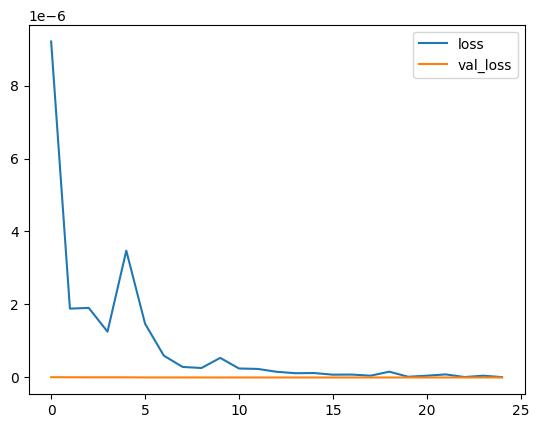

In [29]:
losses[['loss','val_loss']].plot()

In [30]:
from sklearn.metrics import classification_report,confusion_matrix

In [32]:
predict_x=model.predict(X_test) 
classes_x=np.argmax(predict_x,axis=1)

2471/2471 [==============================] - 4s 2ms/step


In [33]:
print(classification_report(y_test,predict_x))

ValueError: Classification metrics can't handle a mix of binary and continuous targets